This notebook attempts to look at the different ways we could forecast COVID-19 cases and their efficacy.

We start by taking the original dataset resampled to give the number of new cases per day. 

In [1]:
import pandas as pd
import numpy as np
import math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Original data grouped to have number of cases per day
df = pd.read_csv('./data/daily.csv')

In [3]:
df.head()

,Unnamed: 0,date_dt,cases,7_day_avg,ds,y
0,0,2020-02-27,1,NaN,2020-02-27,1
1,1,2020-02-28,0,NaN,2020-02-28,0
2,2,2020-02-29,0,NaN,2020-02-29,0
3,3,2020-03-01,0,NaN,2020-03-01,0
4,4,2020-03-02,0,NaN,2020-03-02,0


In [4]:
df['date'] = pd.to_datetime(df['date_dt'])

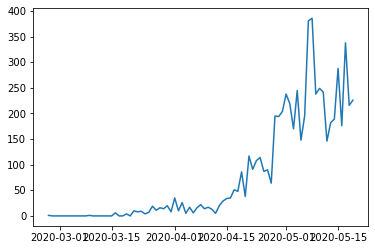

In [5]:
plt.plot(df['date'], df['cases'])

## Prophet

Let's see how FB prophet does at predicting the last 7 days worth of data.

In [6]:
# Try and predict based on data until 27/05/2020
# Try FB prophet for forecasting
from fbprophet import Prophet

# Get the data into somethening prophet can understand
df['ds'] = df['date']
df['y'] = df['cases']

In [7]:
m = Prophet()
m.fit(df[df['date'] <= '2020-05-13'])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [8]:
future = m.make_future_dataframe(periods=7)
future.tail()

,ds
79,2020-05-16
80,2020-05-17
81,2020-05-18
82,2020-05-19
83,2020-05-20


In [9]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
79,2020-05-16,265.879912,218.699843,314.128303
80,2020-05-17,269.107427,222.005671,315.997925
81,2020-05-18,273.152709,224.335426,319.756093
82,2020-05-19,277.197532,224.953395,322.929344
83,2020-05-20,288.969612,241.017844,338.292954


Text(51.5, 0.5, 'New Cases')

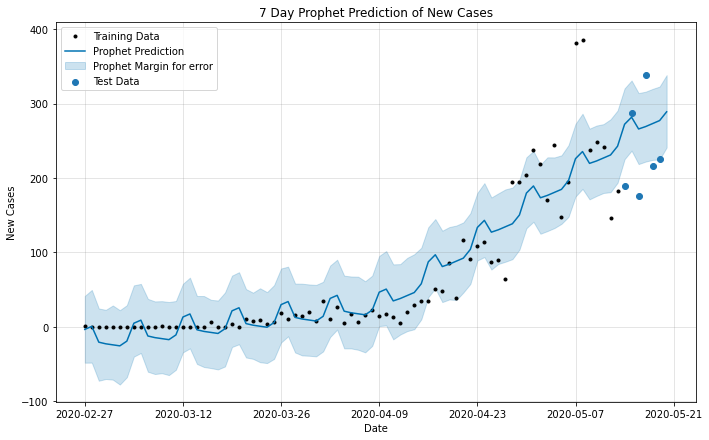

In [10]:
fig1 = m.plot(forecast)
y = df[df['date'] > '2020-05-13']
plt.scatter(y['date'], y['cases'])
plt.legend(('Training Data','Prophet Prediction','Prophet Margin for error','Test Data'))
plt.title('7 Day Prophet Prediction of New Cases')
plt.xlabel('Date')
plt.ylabel('New Cases')

It's OK, but it would be useful to have some sort of metric, let's see what the Mean Average Error and RMSE look like. 

In [11]:
def calc_mae(predictions, targets):
    return np.sum(np.abs(predictions.values - targets.values))/ len(predictions)

def calc_rmse(predictions, targets):
    return np.sqrt(np.mean((predictions.values-targets.values)**2))

predictions = forecast['yhat'][-6:]
targets = y['cases']
rmse = calc_rmse(predictions, targets)
mae = calc_mae(predictions, targets)
print(f'RMSE error: {rmse:.2f}')
print(f'MAE error: {mae:.2f}')

RMSE error: 70.33
MAE error: 66.16


So the error is not great, it seems to miss off the flattening of the curve. 

What if we try predicting the whole of May?

In [12]:
m = Prophet()
m.fit(df[df['date'] < '2020-05-01'])
future = m.make_future_dataframe(periods=19)
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


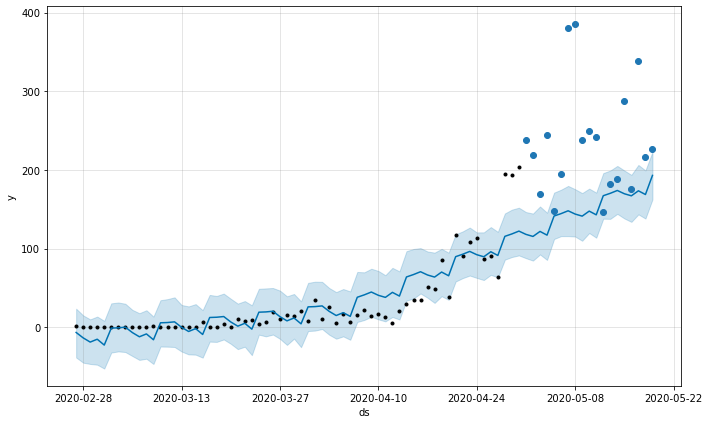

In [13]:
fig1 = m.plot(forecast)
y = df[df['date'] >= '2020-05-01']
plt.scatter(y['date'], y['cases'])

Doesn't look great, but the data is quite noisy. How does it compare to the 7 day average?

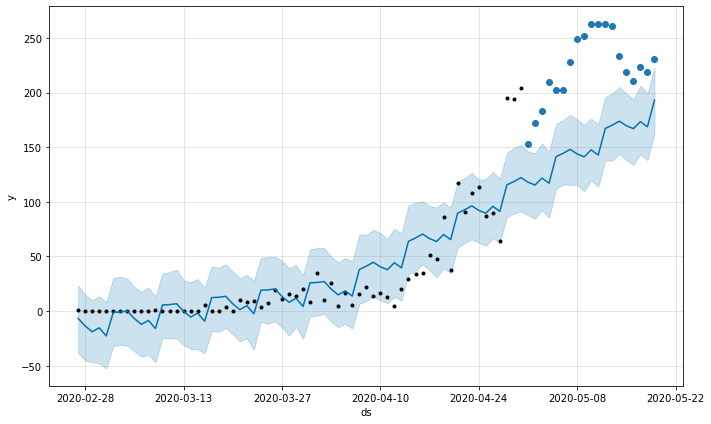

In [14]:
df['7_day_average'] = df.cases.rolling(window=7).mean()
fig1 = m.plot(forecast)
y = df[df['date'] >= '2020-05-01']
plt.scatter(y['date'], y['7_day_average'])

In [15]:
predictions = forecast['yhat'][-19:]
targets = y['cases']
rmse = calc_rmse(predictions, targets)
mae = calc_mae(predictions, targets)
print(f'RMSE error: {rmse:.2f}')
print(f'MAE error: {mae:.2f}')


RMSE error: 110.99
MAE error: 86.81


Interestingly the RMSE is much worse - punished by the large outliers, whilst the MAE is better due to some very close predictions. 

What happens if we train it on the 7 day rolling data?

In [16]:
df['y'] = df['7_day_average']

In [17]:
m = Prophet()
m.fit(df[df['date'] < '2020-05-01'].dropna())
future = m.make_future_dataframe(periods=19)
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


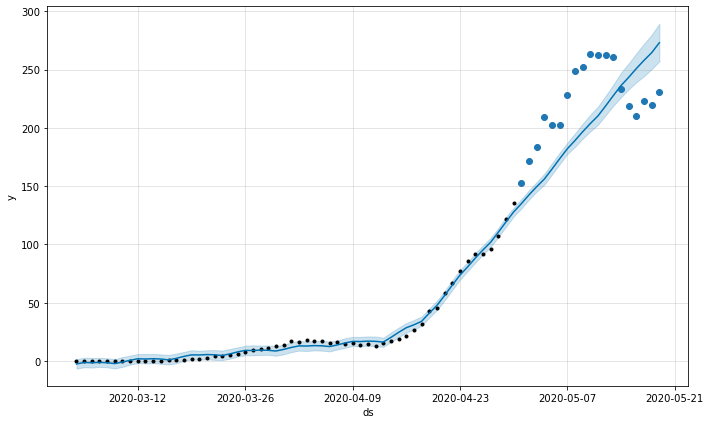

In [18]:
fig1 = m.plot(forecast)
y = df[df['date'] >= '2020-05-01']
plt.scatter(y['date'], y['7_day_average'])

In [19]:
predictions = forecast['yhat'][-19:]
targets = y['cases']
rmse = calc_rmse(predictions, targets)
mae = np.sum(np.abs(predictions - targets))/ len(predictions)
print(f'RMSE error: {rmse:.2f}')
print(f'MAE error: {mae:.2f}')

RMSE error: 84.86
MAE error: 40.82


Whilst the errors are improved, qualitvely the graph is in a linear upward trend, missing the flattening of the curve.

What if we limit the prediction to 7 days, still using the 7 day average?

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
RMSE error: 109.30
MAE error: 96.87


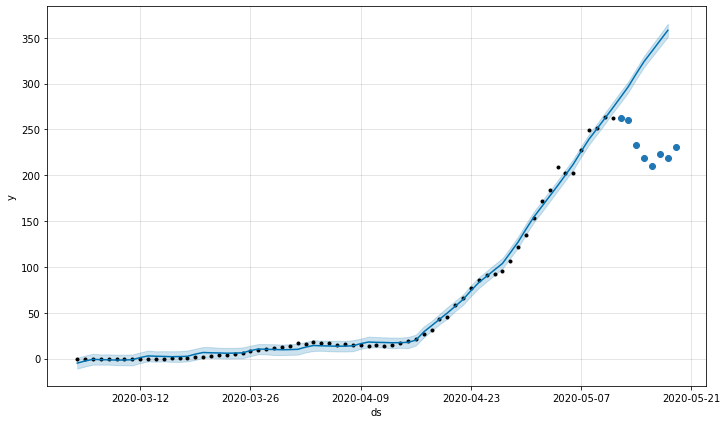

In [20]:
m = Prophet()
m.fit(df[df['date'] < '2020-05-12'].dropna())
future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

fig1 = m.plot(forecast)
y = df[df['date'] >= '2020-05-12']
plt.scatter(y['date'], y['7_day_average'])

predictions = forecast['yhat'][-8:]
targets = y['cases']
rmse = calc_rmse(predictions, targets)
mae = calc_mae(predictions, targets)
print(f'RMSE error: {rmse:.2f}')
print(f'MAE error: {mae:.2f}')


Over 7 days the effect is worse, it completely misses the flattening of the curve. 
In general FB prophet is might capture a general trend but is not great, especially with the limited data we have.

Let's take an expanded data set of cases per day over the whole year, taken from the WHO data set (https://github.com/CSSEGISandData/COVID-19/tree/master/who_covid_19_situation_reports).

In [21]:
df = pd.read_csv('./data/nigeria-cases.csv')
df.head()

,Unnamed: 0,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,58813,2020-01-03,NG,Nigeria,AFRO,0,0,0,0
1,58814,2020-01-04,NG,Nigeria,AFRO,0,0,0,0
2,58815,2020-01-05,NG,Nigeria,AFRO,0,0,0,0
3,58816,2020-01-06,NG,Nigeria,AFRO,0,0,0,0
4,58817,2020-01-07,NG,Nigeria,AFRO,0,0,0,0


Text(0, 0.5, 'New Cases')

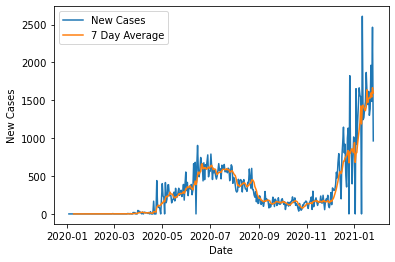

In [22]:
df['Date_reported'] = pd.to_datetime(df['Date_reported'])
df['7_day_average'] = df.New_cases.rolling(window=7).mean()
plt.plot(df['Date_reported'], df['New_cases'])
plt.plot(df['Date_reported'], df['7_day_average'])
plt.legend(('New Cases', '7 Day Average'))
plt.xlabel('Date')
plt.ylabel('New Cases')

In [23]:
# Train Prophet across the whole dataset and see how it compares
from fbprophet.diagnostics import cross_validation
df['ds'] = df['Date_reported']
df['y'] = df['New_cases']
m = Prophet()
m.fit(df)
cv = cross_validation(m,  horizon = '7 days', period='7 days')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 52 forecasts with cutoffs between 2020-01-27 00:00:00 and 2021-01-18 00:00:00


  0%|          | 0/52 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 24.


In [24]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,1 days,28443.170292,168.651031,104.586525,NaN,0.711538
1,2 days,48414.470059,220.032884,131.058627,NaN,0.557692
2,3 days,66485.821681,257.848447,152.640224,NaN,0.423077
3,4 days,82510.118505,287.245746,180.570714,NaN,0.442308
4,5 days,120710.644733,347.434375,204.662118,NaN,0.423077


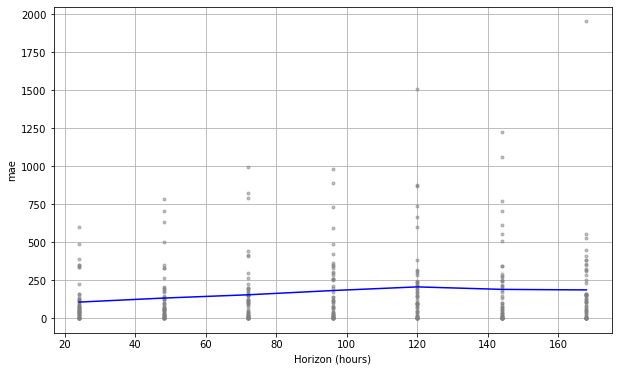

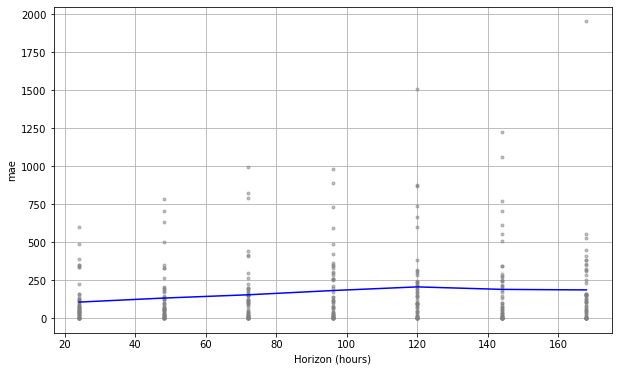

In [25]:
from fbprophet.plot import plot_cross_validation_metric
plot_cross_validation_metric(cv, metric='mae')


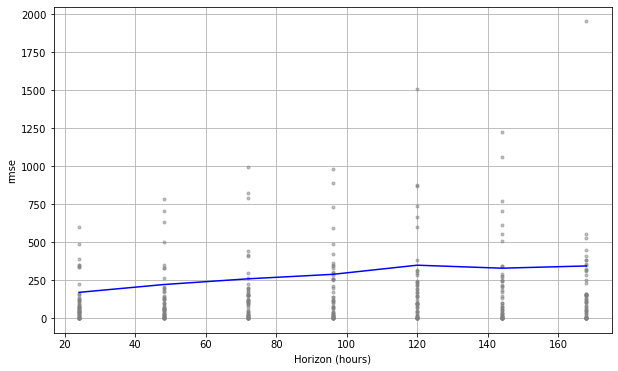

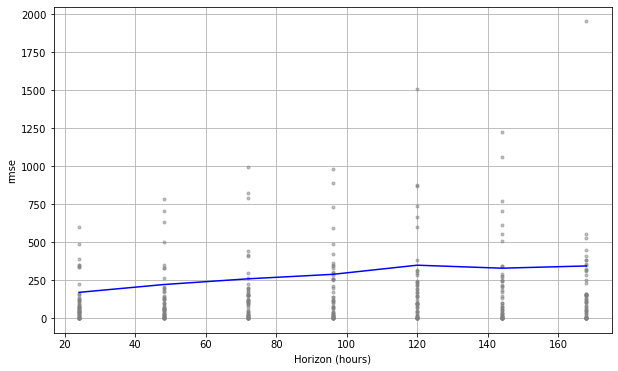

In [26]:
plot_cross_validation_metric(cv, metric='rmse')

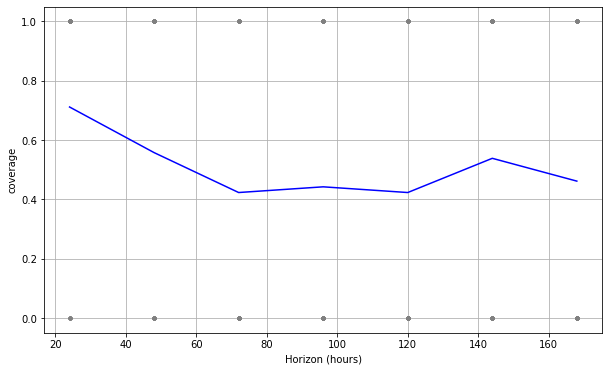

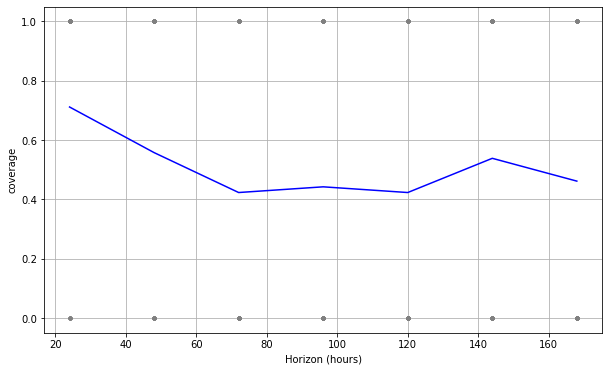

In [27]:
plot_cross_validation_metric(cv, metric='coverage')


In [28]:
# Try a 30 day horizon
df['ds'] = df['Date_reported']
df['y'] = df['New_cases']
m = Prophet()
m.fit(df)
cv = cross_validation(m,  horizon = '30 days')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 18 forecasts with cutoffs between 2020-04-15 00:00:00 and 2020-12-26 00:00:00


  0%|          | 0/18 [00:00<?, ?it/s]

In [29]:
df_p = performance_metrics(cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,3 days,45949.665831,214.358732,166.975730,0.585683,0.351852
1,4 days,29583.331034,171.998055,138.412814,0.622232,0.425926
2,5 days,39047.800645,197.605164,153.670629,0.588305,0.425926
3,6 days,54205.606508,232.820975,167.236448,0.570070,0.444444
4,7 days,79139.873435,281.318100,192.260570,0.592005,0.407407


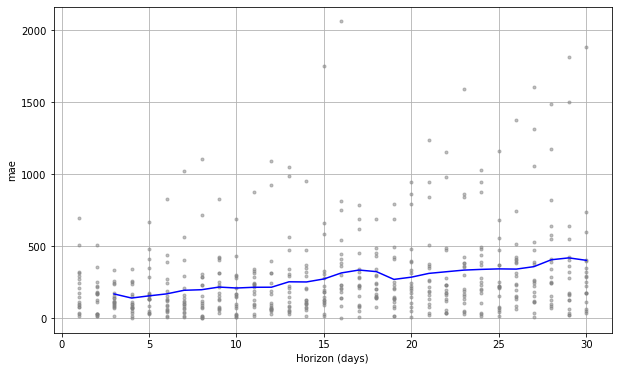

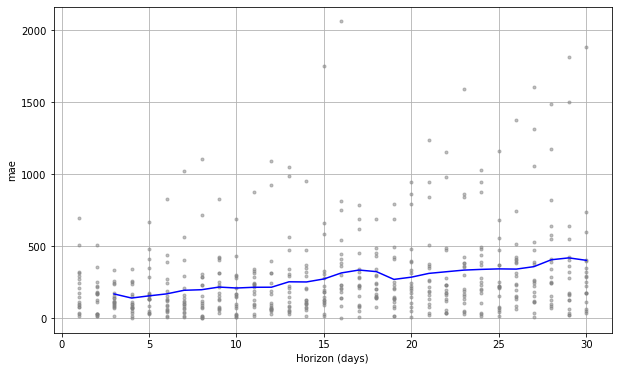

In [30]:
plot_cross_validation_metric(cv, metric='mae')

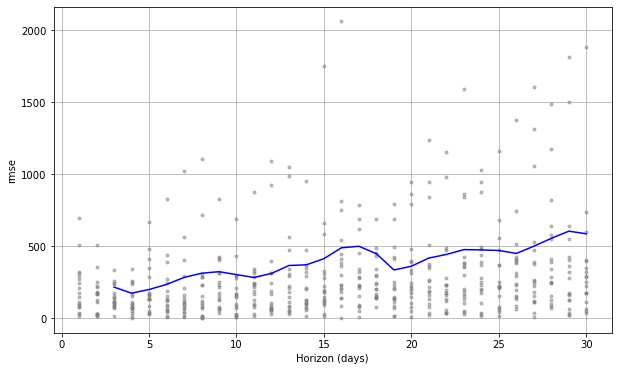

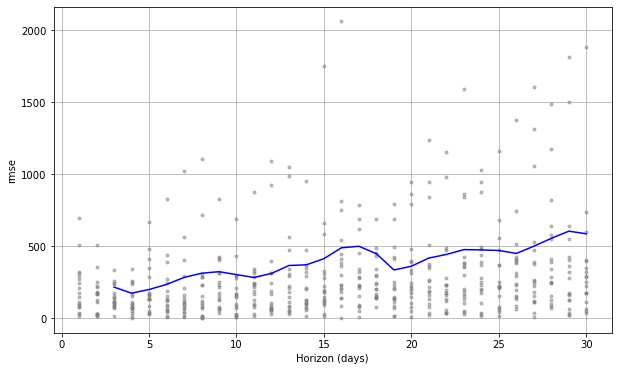

In [31]:
plot_cross_validation_metric(cv, metric='rmse')

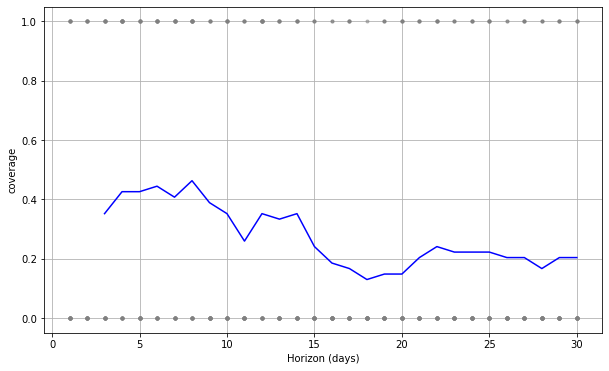

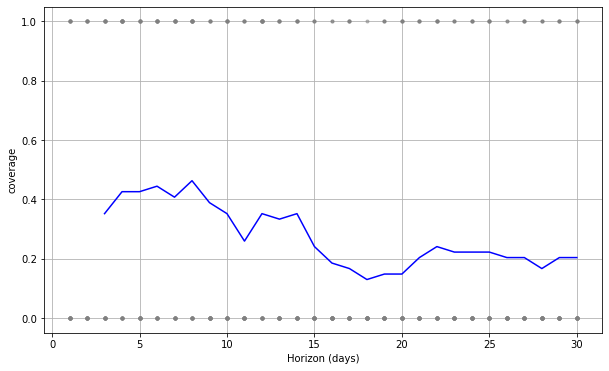

In [32]:
plot_cross_validation_metric(cv, metric='coverage')

Unsurprisingly even training over the whole dataset Prohpet is unable to get good results, likely due to the inherent randomness of the disease spread, at best it may give you a good idea of the next days results, but is not helpful for looking at long term (7 days or more) trends. Given Prophet is more for data that shows some sort of seasonality this is not surprising. 

Prophet is an additive regression model, a more sophisticated Neural Network might yield better results. 




## Tensor Flow

We'll try and use TensorFlow to train a Neural Network to predict the next 7 days of cases, using the expanded data from the past year. 

Code adapted from here: https://www.tensorflow.org/tutorials/structured_data/time_series

In [66]:
# Split the data into train, validation and test
df = df[['y']]
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

# Auto regressive so we only have the one feature, the time series itself 
num_features = 1

In [67]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [68]:
# Predict over 7 days
import os
import sys
module_path = os.path.abspath(os.path.join('./lib'))
if module_path not in sys.path:
    sys.path.append(module_path)
from TensorFlowUtils import FeedBack, compile_and_fit, WindowGenerator
OUT_STEPS=7


### Set Up

We use a WindowGenerator to create a window to run a prediciton on. The input width is the number of samples to train on, OUT_STEPS is the number of steps to predict. Plot takes three random windows and plots the inputs and the windows. 

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30]
Label column name(s): None

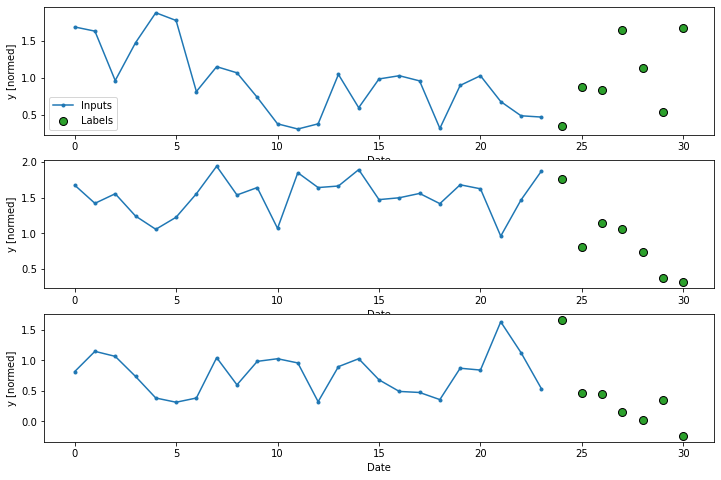

In [69]:
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS, 
                               train_df=train_df,
                               val_df=val_df,
                               test_df=test_df)

multi_window.plot()
multi_window

### Linear Model

As a baseline we us a linear model that will simply predict the last input as the output for the next 7 days. 

2/2 [==============================] - 0s 2ms/step - loss: 0.3362 - mean_absolute_error: 0.4165


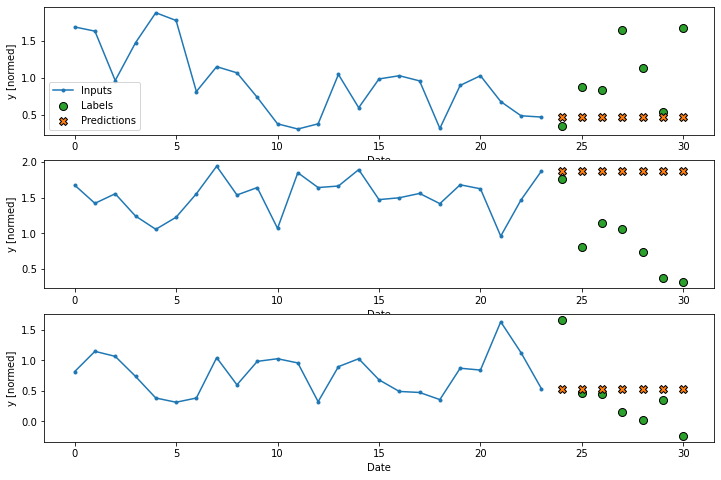

In [70]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)


Let's try a dense model. This adds a dense network layer between the input and the output.  

Epoch 1/20
8/8 [==============================] - 1s 31ms/step - loss: 0.9738 - mean_absolute_error: 0.8428 - val_loss: 0.4558 - val_mean_absolute_error: 0.4629
Epoch 2/20
8/8 [==============================] - 0s 12ms/step - loss: 0.8321 - mean_absolute_error: 0.7657 - val_loss: 0.3933 - val_mean_absolute_error: 0.4180
Epoch 3/20
8/8 [==============================] - 0s 12ms/step - loss: 0.5151 - mean_absolute_error: 0.5840 - val_loss: 0.3462 - val_mean_absolute_error: 0.3903
Epoch 4/20
8/8 [==============================] - 0s 12ms/step - loss: 0.3230 - mean_absolute_error: 0.4297 - val_loss: 0.3337 - val_mean_absolute_error: 0.4116
Epoch 5/20
8/8 [==============================] - 0s 12ms/step - loss: 0.2817 - mean_absolute_error: 0.3386 - val_loss: 0.3260 - val_mean_absolute_error: 0.4209
Epoch 6/20
8/8 [==============================] - 0s 12ms/step - loss: 0.2891 - mean_absolute_error: 0.3375 - val_loss: 0.3114 - val_mean_absolute_error: 0.4072
Epoch 7/20
8/8 [==================

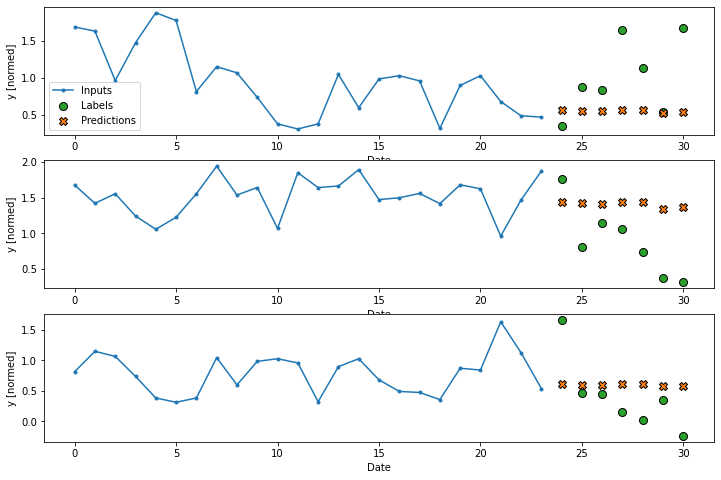

In [71]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)


multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

This doesn't add much. Let's try a more sophisticated RNN. This takes an LSTM (Long Short Term Memory) network and adds a dense layer to it. 

In [72]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)


In [73]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 1])

In [74]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Epoch 1/20
8/8 [==============================] - 3s 85ms/step - loss: 1.0023 - mean_absolute_error: 0.8595 - val_loss: 0.4650 - val_mean_absolute_error: 0.4628
Epoch 2/20
8/8 [==============================] - 0s 19ms/step - loss: 0.6666 - mean_absolute_error: 0.6900 - val_loss: 0.4118 - val_mean_absolute_error: 0.4241
Epoch 3/20
8/8 [==============================] - 0s 17ms/step - loss: 0.3409 - mean_absolute_error: 0.4832 - val_loss: 0.3904 - val_mean_absolute_error: 0.3965
Epoch 4/20
8/8 [==============================] - 0s 21ms/step - loss: 0.2495 - mean_absolute_error: 0.3613 - val_loss: 0.4530 - val_mean_absolute_error: 0.4483
Epoch 5/20
2/2 [==============================] - 0s 4ms/step - loss: 0.4647 - mean_absolute_error: 0.4537


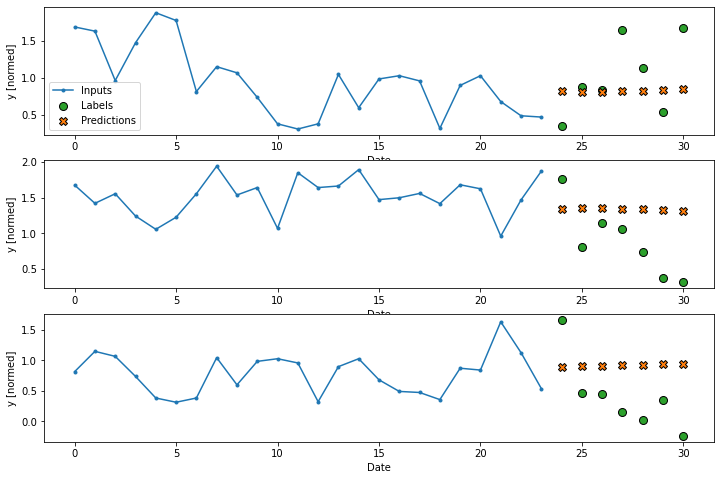

In [75]:
history = compile_and_fit(feedback_model, multi_window)

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

[308.80147012675434, 308.1683643745905, 320.3785431438874]


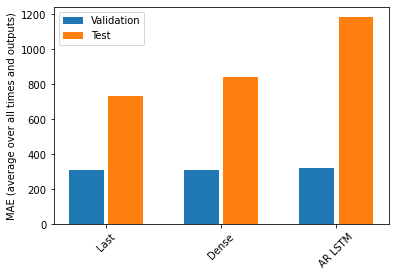

In [76]:

metric_name = 'mean_absolute_error'
metric_index = last_baseline.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]
width = 0.3


denormalised_val_mae = []
denormalised_test_mae = []
for x in val_mae:
    denormalised_val_mae.append(x * train_std[0] + train_mean[0])

for x in test_mae:
    denormalised_test_mae.append( x * train_std[0] + train_mean[0])

print(denormalised_val_mae)

x = np.arange(len(multi_performance))
plt.bar(x - 0.17, denormalised_val_mae, width, label='Validation')
plt.bar(x + 0.17, denormalised_test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

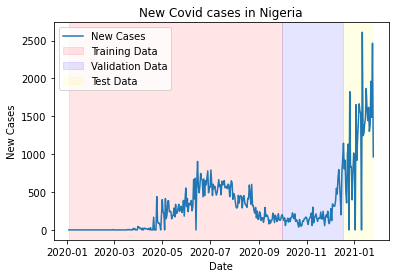

In [77]:
orig_df = pd.read_csv('./data/nigeria-cases.csv')
orig_df['Date_reported'] = pd.to_datetime(orig_df['Date_reported'])
fig, ax = plt.subplots()
ax.plot(orig_df['Date_reported'],orig_df['New_cases'])
plt.title('New Covid cases in Nigeria')
plt.xlabel('Date')
plt.ylabel('New Cases')
total_obs = orig_df.shape[0]
ax.axvspan(orig_df['Date_reported'][0], orig_df['Date_reported'][int(total_obs*0.7)], alpha=0.1, color='red')
ax.axvspan(orig_df['Date_reported'][int(total_obs*0.7)], orig_df['Date_reported'][int(total_obs*0.9)], alpha=0.1, color='blue')
ax.axvspan(orig_df['Date_reported'][int(total_obs*0.9)], orig_df['Date_reported'][total_obs-1], alpha=0.1, color='yellow')
plt.legend(('New Cases','Training Data','Validation Data','Test Data'))



Whilst the validation score isn't bad, the test score is a lot worse. We can see from the way the data is split that there is a new mode of behaviour in the test data, which the model struggles to handle.

It looks like machine learning techniques are going to struggle to make predictions on the base dataset. Ideally we could feed more features into the model, possibly search terms. Alternatively we can use a more traditional modelling approach. 

## SEIR Modelling

In [82]:
df = pd.read_csv('data/nigeria-cases.csv')
df.head()

,Unnamed: 0,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,58813,2020-01-03,NG,Nigeria,AFRO,0,0,0,0
1,58814,2020-01-04,NG,Nigeria,AFRO,0,0,0,0
2,58815,2020-01-05,NG,Nigeria,AFRO,0,0,0,0
3,58816,2020-01-06,NG,Nigeria,AFRO,0,0,0,0
4,58817,2020-01-07,NG,Nigeria,AFRO,0,0,0,0


We can try and use the SEIR model to see if it can model the macro effects of the pandemic.

In [84]:
# The SEIR model differential equations.
def derivSEIR(y, t, lam, alpha, gamma):
    S, E, I, R = y
    dSdt = -lam * I * S
    dEdt = lam * S * I - alpha * E
    dIdt = alpha * E - gamma * I 
    dRdt = gamma * I 
    return dSdt, dEdt, dIdt, dRdt

In [85]:

# Parameters from "Modeling the second wave of COVID-19 infections in France and Italy via a stochastic SEIR model" - Farnanda and Alberit
# https://arxiv.org/abs/2006.05081

# Initial conditions 
# 250 Days
t = np.arange(1,250,1)

# Population of Nigeria
N = 206000000
# 1 Initial infections
I0 = 1
S0 = N - I0
E0 = 0
R0 = 0
y0 = S0, E0, I0, R0
# Parameters
gamma = 0.37
alpha = 0.27
lam = 1 / S0
# Integrate the SIR equations over the time grid, t.
ret = odeint(derivSEIR, y0, t, args=(lam, alpha, gamma))
S, E, I, R = ret.T

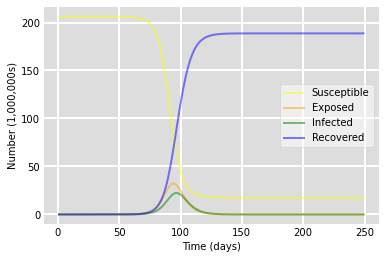

In [86]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000000, 'yellow', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, E/1000000, 'orange', alpha=0.5, lw=2, label='Exposed')
ax.plot(t, I/1000000, 'green', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000000, 'b', alpha=0.5, lw=2, label='Recovered')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Number (1,000,000s)')
# ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

It is important to note that the above graph is the total numnber of people in each category, to match the data we should represent new cases

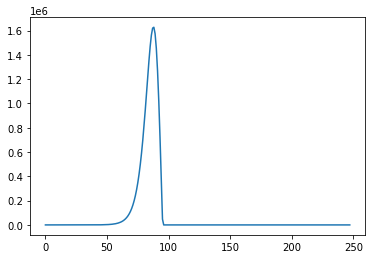

In [88]:
new_cases = []
for i in range(0, len(I) - 1):
    if I[i] < I[i+1]:
        new_cases.append(I[i+1] - I[i])
    else:
        new_cases.append(0)

plt.plot(new_cases)
    

This model much better captures the macro parameters of the epidemic over a large time scale. However there are still limitations, the pandemic only lasts 50 days in this model, vastly overestimates the number of infections and has no second wave. 

Nigeria also went into a lockdown on March 30th which is not taken into account by the model. 

From the same paper above, they intoduce stochastic SEIR equations with an infection rate alpha that varies over time. 

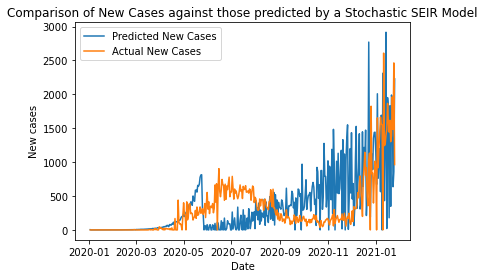

In [58]:

# Parameters from "Modeling the second wave of COVID-19 infections in France and Italy via a stochastic SEIR model"

# Initial down dates 04/05/2020 - 01/06/2020
# Eased over june
# Further eased over July
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7490626/#:~:text=Phases%20of%20the%20lockdown%20in%20Nigeria&text=The%20first%20phase%20of%20the,6%20am%20was%20equally%20announced.


# Population
N = 206000000
# 5 Initial infections
I0 = 1
S0 = N - I0
E0 = 0
R0 = 0
y0 = S0, E0, I0, R0
lam = 1 / S0

# Odeint doesn't like stochastic differential equations so we'll have to write our own solver

#PARAMETER DEFINITIONS
tmax=390
# Number realisations
nrel=100
# tconf: lockdown day
tconf=142
# tconf2: lockdown easing 1
tconf2=tconf + 30
# Lock down easing 2
tconf3=tconf2 + 30
# Lambdas for each lock down period - slowly increasing to show relaxing of measures
lambdaconf = 0.35
lambdares = 0.36
lambdares2 = 0.38

# Store each realistion of infected people in an array
Irel = np.zeros([nrel, tmax])

# Loop on realisations
for rel in range(0,nrel):
    S = np.zeros(tmax)
    E = np.zeros(tmax)
    I = np.zeros(tmax)
    R = np.zeros(tmax)
    S[0] = N
    E[0] = 0
    I[0] = 5
    R[0] = 0
    alpha0=0.27
    gamma0 = 0.35
    lambda0 = 0.51
    for t in range(0,tmax - 1):
        # Adjust lambda over time
        if t == tconf:
            lambda0 = lambdaconf
        if t == tconf2: 
            lambda0 =  lambdares
        if t == tconf3: 
            lambda0 = lambdares2
        # Simulat parameters with noise
        gamma = gamma0 + np.random.normal() * gamma0 / 10
        lam_= (lambda0 + np.random.normal()*lambda0/10) / S[0]
        alpha = alpha0 + np.random.normal() * alpha0 /10 
        # Update equations
        S[t+1] = S[t] - lam_ * S[t] * I[t]
        E[t+1] = E[t] + (lam_ * S[t] * I[t] - alpha * E[t])
        I[t+1] = I[t] + alpha * E[t] - gamma * I[t]
        R[t+1] = R[t] + gamma * I[t]
        # Save I
        Irel[rel,t+1] = I[t+1]

# Calculate mean and standard deviations 
Imean = np.zeros(tmax)
Istd = np.zeros(tmax)
for i in range(0,tmax):
    Imean[i] = np.mean(Irel[:,i])
    Istd[i] = np.std(Irel[:,i])

new_cases = []
for i in range(0, len(Imean) - 1):
    if Imean[i] < Imean[i+1]:
        new_cases.append(Imean[i+1] - Imean[i])
    else:
        new_cases.append(0)

plt.plot(df['Date_reported'], new_cases)
plt.plot(df['Date_reported'], df['New_cases'])
plt.xlabel('Date')
plt.ylabel('New cases')
plt.title('Comparison of New Cases against those predicted by a Stochastic SEIR Model')
plt.legend(('Predicted New Cases','Actual New Cases'))


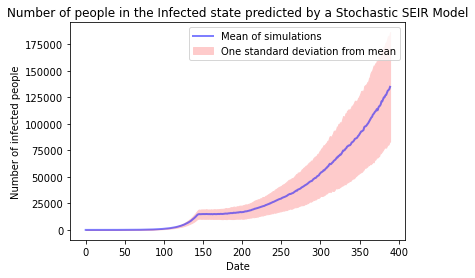

In [63]:
plt.plot(np.arange(0,tmax), Imean, 'r', alpha=0.5, lw=2, label='Infected', color='blue')
plt.fill_between(np.arange(0,tmax), Imean-Istd, Imean + Istd, color=[(255/256,204/256,204/256)])
plt.title('Number of people in the Infected state predicted by a Stochastic SEIR Model')
plt.xlabel('Date')
plt.ylabel('Number of infected people')
plt.legend(('Mean of simulations','One standard deviation from mean'))